In [193]:
include("other_utils.jl")
using ExpDataSets, Dates, CSV, FileIO, JLD2, Chain, DataFrames, DataFramesMeta, StatsBase, Measurements, Plots 


In [3]:
et =  load("Data/freeroam_dataset.jld2", "event_time_series");

In [4]:
ps =  @chain et begin 
    transform(:lfp => ByRow.(x->normalize(x))=>:lfp)
    transform(:lfp => ByRow.(x->binps(compute_power_spectrum(x),100))=>:pspec)
    @select(:rat, :trial_type, :agent, :behavior, :region, :pspec)
end

/Users/leobreston/.julia/conda/3/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 1010 is greater than input length  = 1000, using nperseg = 1000
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/leobreston/.julia/conda/3/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 1010 is greater than input length  = 916, using nperseg = 916
  warnings.warn('nperseg = {0:d} is greater than input length '


,rat,trial_type,agent,behavior,region,pspec
,String7?,String15?,String7?,String15?,String,PowerSp…
1,RRSD17,Freeroam,Rat,Retreat_Rat2,mob,"PowerSpectrum([2.32773e-6, 3.49326e-6, 3.26198e-6, 7.59867e-7, 3.56862e-6, 4.96542e-6, 1.45011e-5, 6.57185e-5, 5.9132e-5, 5.74634e-5, 2.52538e-5, 2.4463e-6, 2.09239e-6, 4.08338e-6, 5.18789e-6, 7.73942e-6, 2.62039e-6, 3.58905e-6, 5.17506e-6, 3.90786e-6, 1.89834e-6, 6.15331e-7, 2.14605e-6, 9.55074e-7, 4.89684e-7, 5.12433e-7, 3.68657e-7, 1.56748e-6, 1.15094e-6, 1.38641e-7, 6.86066e-7, 2.97829e-7, 6.87875e-7, 3.90784e-7, 9.97514e-8, 1.05932e-7, 9.29797e-7, 6.60062e-7, 1.91118e-7, 1.29718e-8, 6.33302e-8, 1.80748e-7, 2.12069e-7, 4.88334e-7, 5.13304e-7, 3.75423e-7, 1.39898e-7, 7.92858e-7, 3.02113e-7, 1.11668e-7, 4.07551e-7, 7.86999e-7, 1.80703e-7, 1.88445e-7, 8.91179e-7, 4.75825e-7, 5.63702e-7, 8.5592e-7, 3.41137e-7, 4.62618e-7, 4.36407e-8, 3.34705e-7, 5.72258e-7, 1.0318e-6, 1.04355e-6, 7.72175e-7, 2.50102e-6, 2.3285e-6, 1.77289e-6, 1.22989e-7, 6.29508e-7, 5.17398e-7, 7.83508e-7, 1.89137e-6, 2.23567e-6, 1.40134e-6, 1.47309e-6, 6.42118e-7, 9.06542e-7, 5.86535e-7, 1.28631e-7, 3.61143e-7, 2.79691e-7, 1.07987e-6, 1.22407e-6, 1.21565e-6, 6.74443e-7, 3.96637e-7, 5.43896e-7, 1.51454e-7, 1.22422e-6, 1.38424e-6, 1.56489e-6, 1.86344e-7, 2.28245e-6, 1.38265e-6, 6.57856e-7, 1.51213e-6, 9.78591e-7, 2.44517e-7], [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0])"
2,RRSD17,Freeroam,Rat,Retreat_Rat2,amyg,"PowerSpectrum([1.00095e-5, 2.56637e-5, 3.86973e-6, 9.659e-6, 2.30057e-5, 2.62414e-5, 1.03311e-5, 6.03722e-6, 2.13852e-5, 2.87091e-5, 6.6136e-6, 1.79763e-6, 2.63029e-6, 3.4215e-6, 6.75323e-6, 2.80592e-6, 1.85401e-6, 1.61055e-6, 7.41278e-6, 8.56632e-6, 4.44675e-6, 1.32838e-6, 3.00555e-6, 2.9521e-6, 1.88563e-6, 3.633e-6, 5.19409e-6, 1.9548e-6, 1.7742e-6, 3.08605e-6, 6.42764e-7, 3.8729e-7, 5.71305e-7, 2.13636e-6, 1.26875e-6, 6.5071e-7, 1.31692e-6, 3.11228e-6, 1.51576e-6, 2.48619e-6, 2.68394e-6, 1.41946e-6, 8.6977e-7, 1.99011e-6, 2.73177e-6, 2.54751e-6, 1.78687e-6, 2.36578e-6, 9.32089e-7, 1.35987e-6, 3.69392e-6, 2.22625e-6, 9.91671e-7, 1.4658e-6, 8.93876e-7, 6.958e-7, 5.6639e-7, 8.20896e-7, 1.33203e-6, 4.78115e-7, 2.51199e-7, 3.42221e-7, 4.74785e-7, 4.70976e-7, 1.3608e-7, 2.69796e-7, 5.64569e-7, 1.15067e-6, 1.2212e-6, 6.77723e-8, 2.22213e-7, 7.24815e-8, 1.17641e-6, 9.59807e-7, 2.01141e-7, 5.34311e-7, 7.40127e-7, 7.47178e-7, 1.05689e-6, 1.23311e-6, 6.911e-7, 4.43588e-7, 4.74942e-7, 2.00727e-6, 2.38475e-6, 8.66796e-7, 4.49757e-7, 1.38194e-6, 1.54507e-6, 8.51987e-7, 1.14927e-6, 2.48291e-6, 2.22633e-6, 6.06973e-7, 1.42644e-7, 8.98859e-7, 7.79369e-7, 5.84434e-7, 7.60348e-7, 1.08914e-6], [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0])"
3,RRSD17,Freeroam,Rat,Retreat_Rat2,ca2,"PowerSpectrum([4.59156e-6, 1.43516e-5, 1.19749e-5, 1.6786e-5, 5.34707e-5, 4.14186e-5, 7.92926e-6, 9.98351e-6, 7.48283e-5, 7.76605e-5, 4.28014e-6, 4.60906e-7, 4.66762e-6, 6.43251e-6, 6

In [7]:
null_region_mps =  @chain ps begin 
    @subset(:behavior.=="null")
    transform(:pspec => ByRow.(x->values(x))=>:pspec)
    groupby([:region])
    @combine(:mps=[meanandstderr(:pspec)])
    transform(:mps=>ByRow.(x->Measurements.value.(x))=>:mpsvals, :mps=>ByRow.(x->Measurements.uncertainty.(x))=>:err)
    select(:region, :mpsvals=>:mps, :err)
end

,region,mps
,String,Array…
1,mob,"[3.1943e-6, 1.65045e-5, 2.20224e-5, 2.34742e-5, 2.1116e-5, 2.21381e-5, 2.77175e-5, 3.25213e-5, 3.65733e-5, 3.06648e-5, 2.14288e-5, 1.06889e-5, 6.91258e-6, 6.12577e-6, 6.02101e-6, 5.31605e-6, 5.2984e-6, 4.94684e-6, 4.53894e-6, 3.88796e-6, 3.51209e-6, 2.65148e-6, 2.13917e-6, 1.86108e-6, 1.70844e-6, 1.44039e-6, 1.23569e-6, 1.19206e-6, 1.1657e-6, 1.0263e-6, 9.58891e-7, 9.55551e-7, 8.8166e-7, 8.44358e-7, 7.19758e-7, 7.61881e-7, 7.86315e-7, 6.92837e-7, 6.73574e-7, 6.17501e-7, 6.4452e-7, 6.56919e-7, 6.26353e-7, 5.43859e-7, 5.11807e-7, 4.88041e-7, 5.50554e-7, 6.0313e-7, 5.71063e-7, 6.03366e-7, 5.45116e-7, 5.43462e-7, 6.60637e-7, 8.03764e-7, 8.17647e-7, 7.33176e-7, 7.26691e-7, 8.65505e-7, 6.33005e-7, 2.23328e-7, 8.43515e-8, 2.77725e-7, 6.21195e-7, 7.66422e-7, 7.85535e-7, 7.78796e-7, 7.81487e-7, 8.48656e-7, 8.94905e-7, 9.3735e-7, 8.15356e-7, 7.3355e-7, 7.65714e-7, 8.35918e-7, 7.91919e-7, 6.72922e-7, 7.01904e-7, 7.85754e-7, 6.80603e-7, 7.09269e-7, 8.25957e-7, 8.08847e-7, 7.70296e-7, 7.20885e-7, 6.72594e-7, 7.71689e-7, 8.37572e-7, 7.56534e-7, 7.29651e-7, 7.55032e-7, 7.7068e-7, 7.25248e-7, 6.90345e-7, 7.33532e-7, 7.01686e-7, 6.60509e-7, 6.62672e-7, 6.58399e-7, 5.74391e-7, 5.99268e-7]"
2,amyg,"[6.39763e-6, 3.31495e-5, 3.2639e-5, 2.29661e-5, 1.63902e-5, 1.25577e-5, 1.25572e-5, 1.73136e-5, 2.57999e-5, 1.8107e-5, 9.71577e-6, 5.90737e-6, 4.256e-6, 3.70674e-6, 3.8351e-6, 3.93369e-6, 3.99485e-6, 3.69794e-6, 3.56626e-6, 3.2518e-6, 2.90626e-6, 2.31885e-6, 2.2744e-6, 2.50619e-6, 2.09767e-6, 1.94633e-6, 1.82133e-6, 1.85223e-6, 1.72744e-6, 1.60397e-6, 1.35342e-6, 1.32191e-6, 1.23324e-6, 1.23714e-6, 1.18584e-6, 1.07756e-6, 1.0865e-6, 1.01211e-6, 9.77026e-7, 9.38696e-7, 9.429e-7, 9.02453e-7, 9.11797e-7, 8.26281e-7, 7.82237e-7, 8.02803e-7, 7.99164e-7, 8.5917e-7, 8.14412e-7, 7.58187e-7, 7.35576e-7, 6.91978e-7, 7.24052e-7, 8.07385e-7, 7.34974e-7, 6.43999e-7, 6.72676e-7, 7.01073e-7, 5.55926e-7, 2.33503e-7, 1.27431e-7, 2.3726e-7, 5.1555e-7, 7.77408e-7, 7.38953e-7, 6.57025e-7, 6.60006e-7, 7.49794e-7, 6.6712e-7, 5.78466e-7, 5.99071e-7, 6.48648e-7, 6.33163e-7, 6.3115e-7, 6.0996e-7, 6.03429e-7, 5.73365e-7, 5.95365e-7, 6.20519e-7, 6.08882e-7, 5.93365e-7, 5.49342e-7, 6.09198e-7, 5.83505e-7, 5.34254e-7, 5.5196e-7, 5.40966e-7, 5.37027e-7, 5.6248e-7, 5.10218e-7, 5.00376e-7, 5.19905e-7, 5.29791e-7, 4.88214e-7, 5.57331e-7, 5.57929e-7, 5.44028e-7, 5.0499e-7, 4.89803e-7, 5.22605e-7]"
3,ca2,"[5.72124e-6, 2.90054e-5, 3.20398e-5, 2.55246e-5, 1.92457e-5, 1.72362e-5, 1.994e-5, 3.90167e-5, 5.91295e-5, 3.58275e-5, 1.42105e-5, 8.17013e-6, 5.76176e-6, 4.66307e-6, 4.17366e-6, 4.07238e-6, 4.17065e-6, 3.81381e-6, 3.29873e-6, 2.9879e-6, 2.82747e-6, 2.50996e-6, 2.52338e-6, 2.43781e-6, 2.20816e-6, 1.81065e-6, 1.58995e-6, 1.58358e-6, 1.38151e-6, 1.26804e-6, 1.14217e-6, 1.09472e-6, 1.10676e-6, 1.18391e-6, 9.99042e-7, 9.50935e-7, 9.20052e-7, 8.62297e-7, 8.1865e-7, 7.24241e-7, 7.80151e-7, 8.51507e-7, 7.81306e-7, 7.99639e-7, 7.21292e-7, 6.82399e-7, 6.25477e-7, 7.19925e-7, 6.7463e-7, 5.95936e-7, 6.13095e-7, 5.3795e-7, 5.00348e-7, 5.19891e-7, 5.25317e-7, 4.70573e-7, 5.14296e-7, 4.7707e-7, 3.28399e-7, 1.30199e-7, 7.21002e-8, 1.52336e-7, 3.56533e-7, 4.2272e-7, 4.32534e-7, 4.01843e-7, 3.86013e-7, 4.06806e-7, 4.30162e-7, 3.64442e-7, 3.72318e-7, 3.67559e-7, 3.18518e-7, 3.30618e-7, 3.25707e-7, 3.14346e-7, 3.17839e-7, 3.61732e-7, 3.55113e-7, 3.37807e-7, 3.43486e-7, 2.98316e-7, 2.97367e-7, 2.95181e-7, 2.84448e-7, 2.80942e-7, 3.00794e-7, 2.83319e-7, 2.9698e-7, 2.79195e-7, 2.6624e-7, 2.58094e-7, 2.54982e-7, 2.66476e-7, 2.6123e-7, 2.5104e-7, 2.71078e-7, 2.89785e-7, 2.79831e-7, 2.63026e-7]"


In [37]:
behavior_agent_mps =  @chain ps begin 
    @subset(:behavior.!="null")
    transform(:pspec => ByRow.(x->values(x))=>:pspec)
    groupby([:behavior, :agent, :region])
    @combine(mps=[meanandstderr(:pspec)])
    transform(:mps=>ByRow.(x->Measurements.value.(x))=>:mpsvals, :mps=>ByRow.(x->Measurements.uncertainty.(x))=>:err)
    select(:behavior, :agent, :region, :mpsvals=>:mps, :err)
end

┌ Warning: Using an un-quoted Symbol on the LHS is deprecated. Write :mps = ... instead.
└ @ DataFramesMeta /Users/leobreston/.julia/packages/DataFramesMeta/yzaoq/src/parsing.jl:298


,behavior,agent,region,mps
,String15?,String7?,String,Array…
1,Retreat_Rat2,Rat,mob,"[3.33041e-6, 2.10367e-5, 2.90817e-5, 2.18864e-5, 1.84409e-5, 1.97655e-5, 2.84511e-5, 3.58208e-5, 3.74474e-5, 3.15947e-5, 2.19746e-5, 1.10562e-5, 6.96365e-6, 6.63062e-6, 5.88034e-6, 5.52434e-6, 4.90258e-6, 4.45159e-6, 4.14993e-6, 3.87539e-6, 3.15282e-6, 2.80875e-6, 1.94349e-6, 1.70622e-6, 1.718e-6, 1.54078e-6, 1.4542e-6, 1.50474e-6, 1.20426e-6, 1.03979e-6, 9.68647e-7, 8.8219e-7, 8.31246e-7, 7.4717e-7, 7.45638e-7, 8.26193e-7, 7.34732e-7, 7.10777e-7, 6.60199e-7, 6.38596e-7, 6.15476e-7, 5.901e-7, 5.57467e-7, 5.47654e-7, 5.32146e-7, 5.10746e-7, 5.17778e-7, 5.43093e-7, 6.30453e-7, 6.11315e-7, 5.11924e-7, 5.13276e-7, 5.93966e-7, 6.99662e-7, 7.53073e-7, 7.20414e-7, 6.52004e-7, 7.43444e-7, 6.80316e-7, 2.86108e-7, 9.61957e-8, 2.73434e-7, 6.73869e-7, 7.88458e-7, 7.54974e-7, 7.93605e-7, 8.1862e-7, 7.96057e-7, 7.48163e-7, 7.66501e-7, 7.13784e-7, 7.7849e-7, 7.9661e-7, 8.65e-7, 8.28072e-7, 6.9476e-7, 6.9623e-7, 7.06064e-7, 7.73248e-7, 7.83028e-7, 8.67285e-7, 8.812e-7, 8.58698e-7, 8.85596e-7, 8.76483e-7, 8.77486e-7, 9.08994e-7, 8.35306e-7, 7.53745e-7, 8.15533e-7, 9.09409e-7, 8.64043e-7, 8.61458e-7, 7.68138e-7, 7.42658e-7, 8.01209e-7, 8.05429e-7, 7.8373e-7, 7.329e-7, 6.90704e-7]"
2,Retreat_Rat2,Rat,amyg,"[4.78946e-6, 3.04256e-5, 3.46432e-5, 2.33188e-5, 1.38245e-5, 1.22829e-5, 1.41254e-5, 1.80358e-5, 2.64703e-5, 1.9188e-5, 9.65605e-6, 5.0911e-6, 4.15386e-6, 3.71919e-6, 3.08504e-6, 3.24172e-6, 3.39397e-6, 3.31154e-6, 3.29572e-6, 2.79229e-6, 2.86043e-6, 2.67312e-6, 2.17784e-6, 2.14309e-6, 1.98499e-6, 1.99086e-6, 1.88014e-6, 1.93168e-6, 2.06916e-6, 1.71705e-6, 1.35077e-6, 1.2449e-6, 1.21771e-6, 1.06159e-6, 1.1223e-6, 1.16506e-6, 1.0893e-6, 1.02261e-6, 1.00949e-6, 9.58977e-7, 8.90186e-7, 9.2322e-7, 1.02818e-6, 8.5431e-7, 8.64018e-7, 8.07263e-7, 8.45103e-7, 7.73547e-7, 6.96653e-7, 6.74133e-7, 7.14946e-7, 7.31959e-7, 6.7291e-7, 8.09051e-7, 8.01608e-7, 7.09453e-7, 7.65959e-7, 7.43858e-7, 5.98799e-7, 2.54852e-7, 1.52236e-7, 2.5419e-7, 4.76416e-7, 5.88283e-7, 5.91604e-7, 5.50412e-7, 6.136e-7, 6.38786e-7, 6.5817e-7, 6.0138e-7, 5.03306e-7, 5.76258e-7, 5.69727e-7, 5.5059e-7, 5.9416e-7, 5.73261e-7, 5.49917e-7, 5.75989e-7, 5.33472e-7, 6.08473e-7, 5.93529e-7, 6.07513e-7, 5.75051e-7, 6.2679e-7, 6.38612e-7, 5.6395e-7, 6.25417e-7, 6.08517e-7, 6.10345e-7, 6.25299e-7, 5.84605e-7, 5.39976e-7, 5.24171e-7, 6.04692e-7, 5.62261e-7, 6.06034e-7, 6.07934e-7, 5.45581e-7, 5.16079e-7, 5.14978e-7]"
3,Retreat_Rat2,Rat,ca2,"[3.93354e-6, 2.16117e-5, 2.47107e-5, 2.05537e-5, 1.42613e-5, 1.41941e-5, 2.24177e-5, 3.82281e-5, 6.64588e-5, 4.32504e-5, 1.38735e-5, 6.04373e-6, 5.1755e-6, 4.11951e-6, 3.56398e-6, 3.3194e-6, 3.70167e-6, 3.46736e-6, 3.24391e-6, 2.81821e-6, 2.86807e-6, 2.52038e-6, 2.33811e-6, 2.17059e-6, 1.90328e-6, 1.75748e-6, 1.85709e-6, 1.94738e-6, 1.90197e-6, 1.55663e-6, 1.31412e-6, 1.1236e-6, 1.10793e-6, 1.03633e-6, 9.69923e-7, 9.63146e-7, 8.71906e-7, 7.65951e-7, 7.42697e-7, 7.72399e-7, 8.90669e-7, 9.06713e-7, 8.15587e-7, 7.001e-7, 6.3868e-7, 6.61983e-7, 6.52505e-7, 6.02918e-7, 5.9109e-7, 5.68519e-7, 6.13858e-7, 6.48203e-7, 6.24574e-7, 6.63245e-7, 6.95128e-7, 6.37694e-7, 6.16331e-7, 5.3604e-7, 3.80651e-7, 1.72227e-7, 8.45432e-8, 1.9537e-7, 4.37742e-7, 4.21299e-7, 4.26881e-7, 4.44461e-7, 4.43192e-7, 4.19476e-7, 3.98614e-7, 3.62643e-7, 3.52578e-7, 3.6795e-7, 3.26864e-7, 3.57848e-7, 3.73293e-7, 3.40594e-7, 3.30593e-7, 3.41171e-7, 2.9111e-7, 3.08516e-7, 3.41916e-7, 3.97038e-7, 4.24426e-7, 4.25054e-7, 3.54701e-7, 3.06727e-7, 3.1116e-7, 3.14164e-7, 3.09783e-7, 3.18482e-7, 3.13636e-7, 3.06938e-7, 2.71806e-7, 3.32333e-7, 3.31694e-7, 3.11137e-7, 3.1821e-7, 3.25896e-7, 3.05805e-7, 3.07734e-7]"
4,Retreat_Rat,Rat,mob,"[3.93476e-6, 1.8388e-5, 2.54227e-5, 2.26598e-5, 1.97156e-5, 1.96113e-5, 2.82522e-5, 3.47857e-5, 3.56846e-5, 3.37589e-5, 2.108e-5, 1.0624e-5, 7.22004e-6, 7.08572e-6, 6.71755e-6, 6.0207e-6, 5.30217e-6, 4.87611e-6, 4.46441e-6, 4.1394e-6, 3.7887e-6, 3.31176e-6, 2.58212e-6, 2.21062e-6, 2.051

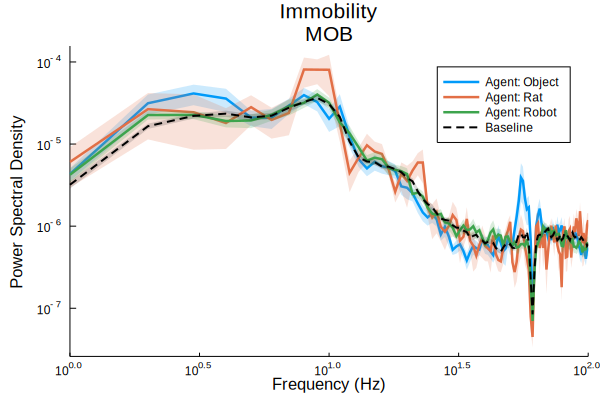

In [213]:
freqs=1:1:100;  b="Immobility"; r="MOB"
s=@subset(behavior_agent_mps, :behavior.== b, :region.== lowercase(r))
s=@orderby(s, :agent)
labels =reshape(s.agent,1,length(s.agent)) 
labels =map(x->"Agent: "*x, labels)
specs = s.mps
errs = s.err

gr()
p=plot(
    freqs, 
    specs, 
    ribbon=errs, 
    fillalpha=.2, 
    label=labels, 
    xaxis=:log,
    yaxis=:log, 
    ylabel="Power Spectral Density", 
    xlabel="Frequency (Hz)", 
    title=b*"\n"*r,
    linewidth=2.5,
    grid=false,
    
)
ns=@subset(null_region_mps, :region.== lowercase(r))
plot!(p, freqs, ns.mps, ribbon= ns.err, fillcolor=:black, fillalpha=.15, linewidth=2,  xlim=(1,100), linestyle=:dash, linecolor=:black, label="Baseline")




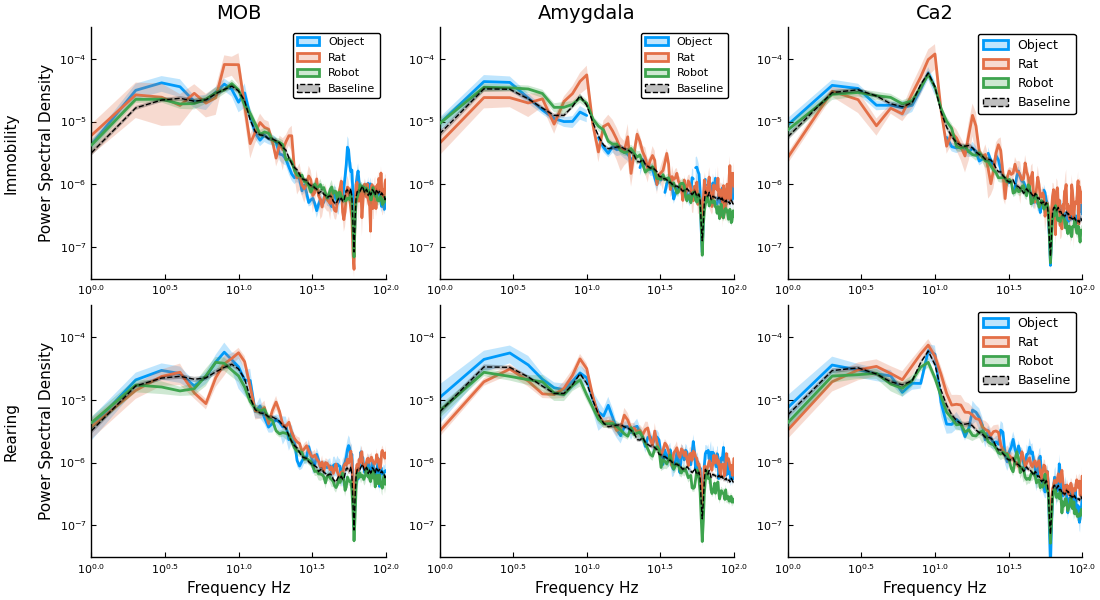

sys:1: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
sys:1: MatplotlibDeprecationWarning: The 'linthreshx' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
sys:1: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
sys:1: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


In [207]:
import PyPlot
pyplot()
imm_mob=agent_ps_plot(behavior_agent_mps, null_region_mps, "Immobility", "MOB")
plot!(imm_mob, title="MOB", xlabel="", ylabel="Immobility\n\nPower Spectral Density", legend=true)
imm_amyg=agent_ps_plot(behavior_agent_mps, null_region_mps, "Immobility", "Amyg")
plot!(imm_amyg, title="Amygdala", xlabel="", legend=true)
imm_ca=agent_ps_plot(behavior_agent_mps, null_region_mps, "Immobility", "CA2")
plot!(imm_ca, title="Ca2", xlabel="", legendfontsize = 9, legend = :topright)
rear_mob=agent_ps_plot(behavior_agent_mps, null_region_mps, "Rearing", "MOB")
plot!(rear_mob, title="", xlabel="Frequency Hz", ylabel="Rearing\n\nPower Spectral Density")
rear_amyg=agent_ps_plot(behavior_agent_mps, null_region_mps, "Rearing", "Amyg")
plot!(rear_amyg, title="", xlabel="Frequency Hz")
rear_ca=agent_ps_plot(behavior_agent_mps, null_region_mps, "Rearing", "CA2")
plot!(rear_ca, title="", xlabel="Frequency Hz", legendfontsize = 9, legend = :topright)

p=plot(imm_mob, imm_amyg, imm_ca, rear_mob, rear_amyg, rear_ca)
plot!(p, grid=false, size = (1100, 600))
plot!(p, yticks=[10.0^x for x in -7:1:-4], ylim=(10.0^-7.5, 10.0^-3.5), xlim=(1,100))
# plot!(p, linestyle=[:solid :solid :solid :dash], linewidth=[3 3 3 3])

# PyPlot.suptitle("Region")
# PyPlot.savefig("suptile_test.png")
